In [1]:
#Import
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from random import randint
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [2]:
#load data
Data_clean = pd.read_excel('data_balanced.xlsx')

In [3]:
#get info
Data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41978 entries, 0 to 41977
Data columns (total 21 columns):
month                  41978 non-null int64
Age                    41978 non-null int64
Amount_netCN           41978 non-null float64
TermOfPaymentDays      41978 non-null int64
GDP by State           41978 non-null int64
Unemployment rate      41978 non-null float64
ZIP                    41978 non-null int64
DefaultStatus          41978 non-null int64
month1                 41978 non-null int64
month2                 41978 non-null int64
month3                 41978 non-null int64
month4                 41978 non-null int64
month5                 41978 non-null int64
month6                 41978 non-null int64
month7                 41978 non-null int64
month8                 41978 non-null int64
month9                 41978 non-null int64
month10                41978 non-null int64
month11                41978 non-null int64
month12                41978 non-null int64
Feq_def

In [4]:
# Check null value (Print a null value column array)
print(Data_clean.columns[Data_clean.isnull().any()])

Index([], dtype='object')


In [5]:
#Create features and target
X = Data_clean.loc[:, Data_clean.columns != "DefaultStatus"]
y = Data_clean[["DefaultStatus"]]

#Scale data (need to be scale this way (array) in order to combine models in ensemble)

################### can not scale this way, even it works too
# #Scale data
# scaler = MinMaxScaler()
# #Create a pipline
# pipeline = make_pipeline(scaler, clf_gbt)
# pipeline.fit(X_train, np.ravel(y_train))

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=123)

In [6]:
# Train the Xgboost model on the training data
clf_gbt = xgb.XGBClassifier()
clf_gbt.fit(X_train, np.ravel(y_train))

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [7]:
# Setup the hyperparameter grid
max_depth = [3, 7, 10]
gbm_param_grid = {'learning_rate': [0.1, 0.15, 0.2],
'n_estimators': [ 120, 140, 160], 
'max_depth': max_depth }
#'subsample': [0.3, 0.5, 0.9]

# Instantiate the GridSearchCV object: grid_mse
grid_mse = GridSearchCV(estimator=clf_gbt,param_grid=gbm_param_grid,
scoring='roc_auc', cv=5, verbose=1)

# Fit it to the data
grid_mse.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  9.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster=None,
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints=None,
                                     n_estima...
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method=None,
            

In [8]:
# Print the tuned parameters and score
print("Best parameters found: ",grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Best parameters found:  {'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 160}
Lowest RMSE found:  0.9038032718641703


In [9]:
#Get the best params for the model
clf_gbt = xgb.XGBClassifier(**grid_mse.best_params_)

#Fit data
clf_gbt.fit(X_train, np.ravel(y_train))

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.15, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=160, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [10]:
# Predict with a model
gbt_preds = clf_gbt.predict_proba(X_test)   #gbt_preds is proba

# Create dataframes of predictions and true labels
preds_df = pd.DataFrame(gbt_preds[:,1][:], columns = ['prob_default'])
true_df = y_test

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), preds_df ], axis = 1))

DefaultStatus  prob_default
0                  1      0.518735
1                  1      0.686979
2                  0      0.069546
3                  0      0.279931
4                  0      0.649320
...              ...           ...
12589              1      0.362223
12590              0      0.884443
12591              1      0.725459
12592              1      0.476758
12593              1      0.127788

[12594 rows x 2 columns]


In [11]:
# Create a dataframe for the probabilities of default
gbt_preds_df = pd.DataFrame(gbt_preds[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
gbt_preds_df['DefaultStatus'] = gbt_preds_df['prob_default'].apply(lambda x: 1 if x > 0.25 else 0)  # threshold 0.25

In [12]:
# Print the row counts for each default status
print(gbt_preds_df['DefaultStatus'].value_counts())

1    9562
0    3032
Name: DefaultStatus, dtype: int64


In [13]:
# Print the classification report of the model
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds_df['DefaultStatus'], target_names=target_names))

precision    recall  f1-score   support

 Non-Default       0.85      0.42      0.56      6207
     Default       0.62      0.93      0.74      6387

    accuracy                           0.68     12594
   macro avg       0.73      0.67      0.65     12594
weighted avg       0.73      0.68      0.65     12594



In [14]:
#Print confusion matrix
print(confusion_matrix(y_test, gbt_preds_df['DefaultStatus']))

[[2576 3631]
 [ 456 5931]]


In [15]:
# #Print AUC score
# print(roc_auc_score(y_test, gbt_preds_df['DefaultStatus']))

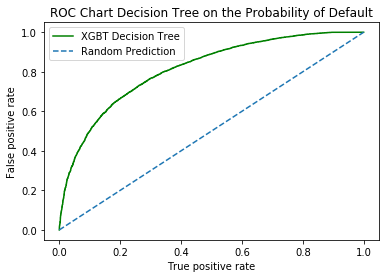

In [22]:
# ROC chart components
fallout_gbt, sensitivity_gbt, thresholds_gbt = roc_curve(y_test, gbt_preds[:,1])

# Plot the ROC curve of the probabilities of default
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'XGBT Decision Tree')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart Decision Tree on the Probability of Default")
plt.xlabel('True positive rate')   #'Fall-out'
plt.ylabel('False positive rate')  #'Sensitivity'
plt.legend()
plt.show()

In [17]:
# # Compute the AUC and store it in a variable
# print(roc_auc_score(y_test, gbt_preds[:,1]))

In [18]:
#save model
import pickle
filename = 'Decisison tree.sav'
pickle.dump(clf_gbt, open(filename, 'wb'))

In [19]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.predict_proba(X_test)

array([[0.48126495, 0.51873505],
       [0.31302088, 0.6869791 ],
       [0.930454  , 0.06954597],
       ...,
       [0.2745412 , 0.7254588 ],
       [0.5232419 , 0.47675812],
       [0.87221247, 0.12778755]], dtype=float32)

In [21]:
# Compute the AUC and store it in a variable
print(roc_auc_score(y_test, gbt_preds[:,1]))

0.8137217814631678
